En esta notebook:



*   ETM para DistilBERT
*  vMF para DistilBERT


# ETM para DistilBERT

VAMOS a:

implementar un modelo ETM (Embedded Topic Model) usando Distilbert en cada texto de la columna text del DataFrame df_newsgroups y guardar el resultado como una nueva columna, sigue estos pasos:



Preparar el ETM: Usa un modelo ETM con los embeddings obtenidos. Un ETM normalmente necesita representaciones de los textos en un espacio de baja dimensionalidad y una lista de palabras para modelar los temas. Usamos los topicos originales para modelar los temas

Implementar el ETM: usamos una librería como PyTorch para crear y entrenar el ETM. Define una arquitectura que tome los embeddings de DistilBert como entrada y genere los temas.

Guardar el Output: Luego de entrenar el ETM, aplicamos el modelo a cada documento para generar su asignación de tema. Guarda este output en una nueva columna, por ejemplo, etm_topic.

Calculamos el porcentaje de documentos por tópico que fueron asignados correctamente, las correpondientes matrices de confusión y la coherencia c_v.

In [ ]:
!pip install torch torchvision
!pip install octis
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 52.1 MB/s eta 0:00:00
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp310-cp310-linux_x86_64.whl size=251406 sha256=34a4bc94c310037138c728a2fe70d959fd61cedb53c8b7fd20c6d052eabd21f5
  Stored in directory: /root/.cache/pip/wheels/79/c7/19/a8c85928f8e629654b8e1adb3c8091f0bb77344d0ee9954a85
Successfully built libsvm
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.

In [ ]:
!pip install -q torch torchvision octis gensim

VAMOS a hacer:

implementar un modelo ETM (Embedded Topic Model) usando Doc2Vec en cada texto de la columna text del DataFrame df_newsgroups y guardar el resultado como una nueva columna, sigue estos pasos:

Entrenar Doc2Vec: Primero, entrena un modelo Doc2Vec con los textos en df_newsgroups para obtener los embeddings de los documentos.

Preparar el ETM: Usa un modelo ETM con los embeddings obtenidos de Doc2Vec. Un ETM normalmente necesita representaciones de los textos en un espacio de baja dimensionalidad y una lista de palabras para modelar los temas. Usamos los topicos originales para modelar los temas

Implementar el ETM: Puedes usar una librería como PyTorch para crear y entrenar el ETM. Define una arquitectura que tome los embeddings de Doc2Vec como entrada y genere los temas.

Guardar el Output: Luego de entrenar el ETM, puedes aplicar el modelo a cada documento para generar su asignación de tema. Guarda este output en una nueva columna, por ejemplo, etm_topic.

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

# Descargar el conjunto de datos 20 Newsgroups
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Crear un DataFrame a partir de los datos de newsgroups, incluyendo las etiquetas y los nombres de los tópicos
df_newsgroups = pd.DataFrame({
    'text': newsgroups_data.data,  # Los textos de los documentos
    'label': newsgroups_data.target,  # Las etiquetas de los documentos
    'topic': [newsgroups_data.target_names[label] for label in newsgroups_data.target]  # Los nombres de los tópicos
})

# Guardar el DataFrame en un archivo CSV
df_newsgroups.to_csv('20newsgroups_data_with_topics.csv', index=False)

# Mostrar el DataFrame creado
df_newsgroups.head()  # Mostrar las primeras filas del DataFrame


,text,label,topic
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware


In [ ]:
#Hacemos el embedding de text con DistilBert
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertModel

# Initialize DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to get DistilBERT embeddings for each document
def get_distilbert_embeddings(texts, batch_size=8):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        # Batch processing to avoid memory overload
        batch_texts = texts[i:i+batch_size]
        # Tokenize the batch
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Get embeddings
        with torch.no_grad():
            outputs = model(**inputs)

        # Use the CLS token (first token) representation as the embedding
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.extend(batch_embeddings)

    return embeddings

# Step 1: Apply the embedding function to get embeddings for all texts
texts = df_newsgroups['text'].tolist()
distilbert_embeddings = get_distilbert_embeddings(texts)

# Step 2: Add the embeddings to the DataFrame
df_newsgroups['distilbert_vector'] = distilbert_embeddings

# Display the first few rows to confirm
print(df_newsgroups[['text', 'distilbert_vector']].head())



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

                                                text  \
0  \n\nI am sure some bashers of Pens fans are pr...   
1  My brother is in the market for a high-perform...   
2  \n\n\n\n\tFinally you said what you dream abou...   
3  \nThink!\n\nIt's the SCSI card doing the DMA t...   
4  1)    I have an old Jasmine drive which I cann...   

                                   distilbert_vector  
0  [-0.009046937, -0.19225115, -0.21939921, 0.061...  
1  [-0.12930581, -0.105506726, 0.019848445, -0.05...  
2  [0.013382249, 0.18851815, -0.08755682, -0.2655...  
3  [-0.45548785, -0.23518702, -0.04610508, 0.1003...  
4  [-0.1602896, -0.04452677, 0.0092704715, -0.197...  


In [ ]:
#Aplicamos ETM
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder

# Paso 2: Codificar los tópicos en formato numérico
label_encoder = LabelEncoder()
df_newsgroups['topic_encoded'] = label_encoder.fit_transform(df_newsgroups['topic'])

# Paso 3: Implementar el ETM usando PyTorch
# Definir el modelo ETM basado en los embeddings de LDA y tópicos
class ETM(torch.nn.Module):
    def __init__(self, input_dim, num_topics):
        super(ETM, self).__init__()
        self.fc = torch.nn.Linear(input_dim, num_topics)

    def forward(self, x):
        return torch.nn.functional.softmax(self.fc(x), dim=1)

# Configuración de los parámetros del modelo
num_topics = len(df_newsgroups['topic'].unique())
input_dim = len(df_newsgroups['distilbert_vector'][0])  # Dimensión de los vectores LDA
etm_model = ETM(input_dim=input_dim, num_topics=num_topics)

# Convertir los embeddings dedistilbert y las etiquetas de tópicos a tensores
lda_embeddings_tensor = torch.tensor(df_newsgroups['distilbert_vector'].tolist(), dtype=torch.float)
topic_labels = torch.tensor(df_newsgroups['topic_encoded'].values, dtype=torch.long)

# Configuración del optimizador y la función de pérdida
optimizer = torch.optim.Adam(etm_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Entrenamiento básico del ETM
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = etm_model(lda_embeddings_tensor)
    loss = criterion(outputs, topic_labels)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

# Paso 4: Asignar temas generados a cada documento
with torch.no_grad():
    df_newsgroups['etm_topic'] = etm_model(lda_embeddings_tensor).argmax(dim=1).numpy()

# Decodificar los temas generados a etiquetas originales de la columna 'topic'
df_newsgroups['etm_topic'] = label_encoder.inverse_transform(df_newsgroups['etm_topic'])

# Mostrar los primeros resultados
print(df_newsgroups[['text', 'topic', 'etm_topic']].head())



<ipython-input-12-2469b2024ed3>:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  lda_embeddings_tensor = torch.tensor(df_newsgroups['distilbert_vector'].tolist(), dtype=torch.float)


Epoch [0/100], Loss: 2.9950
Epoch [10/100], Loss: 2.7112
Epoch [20/100], Loss: 2.6103
Epoch [30/100], Loss: 2.5755
Epoch [40/100], Loss: 2.5566
Epoch [50/100], Loss: 2.5417
Epoch [60/100], Loss: 2.5187
Epoch [70/100], Loss: 2.5045
Epoch [80/100], Loss: 2.4951
Epoch [90/100], Loss: 2.4813
                                                text  \
0  \n\nI am sure some bashers of Pens fans are pr...   
1  My brother is in the market for a high-perform...   
2  \n\n\n\n\tFinally you said what you dream abou...   
3  \nThink!\n\nIt's the SCSI card doing the DMA t...   
4  1)    I have an old Jasmine drive which I cann...   

                      topic                 etm_topic  
0          rec.sport.hockey          rec.sport.hockey  
1  comp.sys.ibm.pc.hardware              misc.forsale  
2     talk.politics.mideast     talk.politics.mideast  
3  comp.sys.ibm.pc.hardware  comp.sys.ibm.pc.hardware  
4     comp.sys.mac.hardware  comp.sys.ibm.pc.hardware  


Calculamos c_v

The coherence measure, c_v, is a popular metric that combines indirect cosine similarity with aggregation,

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim

# Preprocess text into tokens for coherence calculation
df_newsgroups['tokens'] = df_newsgroups['text'].apply(lambda x: gensim.utils.simple_preprocess(x))

# Group tokens by the assigned ETM topic, and flatten each group to get a single list of words per topic
topic_words = df_newsgroups.groupby('etm_topic')['tokens'].apply(lambda docs: [word for tokens in docs for word in tokens]).tolist()

# Create a Gensim dictionary from all tokens
dictionary = Dictionary(df_newsgroups['tokens'])

# Compute coherence score using c_v (you can change this to u_mass, c_uci, or c_npmi if preferred)
coherence_model = CoherenceModel(topics=topic_words, texts=df_newsgroups['tokens'].tolist(),
                                 dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f"Coherence score for ETM topics: {coherence_score:.4f}")



Coherence score for ETM topics: 0.3674


In [ ]:
df_newsgroups[:10]

,text,label,topic,distilbert_vector,topic_encoded,etm_topic,tokens
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,"[-0.009046761, -0.19225124, -0.21939902, 0.061...",10,rec.sport.hockey,"[am, sure, some, bashers, of, pens, fans, are,..."
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,"[-0.12930581, -0.10550669, 0.019848287, -0.055...",3,misc.forsale,"[my, brother, is, in, the, market, for, high, ..."
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,"[0.013382235, 0.18851829, -0.08755669, -0.2655...",17,talk.politics.mideast,"[finally, you, said, what, you, dream, about, ..."
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,"[-0.455488, -0.2351872, -0.04610482, 0.1003923...",3,comp.sys.ibm.pc.hardware,"[think, it, the, scsi, card, doing, the, dma, ..."
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,"[-0.1602897, -0.04452682, 0.009270257, -0.1979...",4,comp.sys.ibm.pc.hardware,"[have, an, old, jasmine, drive, which, cannot,..."
5,\n\nBack in high school I worked as a lab assi...,12,sci.electronics,"[-3.0061858e-05, -0.012632432, -0.2691953, -0....",12,sci.electronics,"[back, in, high, school, worked, as, lab, assi..."
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,4,comp.sys.mac.hardware,"[0.008777524, -0.262973, 0.16997282, -0.038989...",4,sci.electronics,"[ae, is, in, dallas, try, or, tech, support, m..."
7,"\n[stuff deleted]\n\nOk, here's the solution t...",10,rec.sport.hockey,"[-0.15373003, 0.00047762913, -0.11355538, -0.0...",10,rec.sport.hockey,"[stuff, deleted, ok, here, the, solution, to, ..."
8,"\n\n\nYeah, it's the second one. And I believ...",10,rec.sport.hockey,"[-0.09745612, -0.24523911, -0.13571888, -0.208...",10,rec.sport.hockey,"[yeah, it, the, second, one, and, believe, tha..."
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,"[0.15699857, 0.03618659, -0.14255995, -0.17546...",19,soc.religion.christian,"[if, christian, means, someone, who, believes,..."


In [ ]:
# Contar coincidencias entre 'topic' y 'etm_topic'
coincidencias = (df_newsgroups['topic'] == df_newsgroups['etm_topic']).sum()

# Mostrar el número de coincidencias
print(f"El número de documentos en los que coinciden 'topic' y 'etm_topic' es: {coincidencias}")


El número de documentos en los que coinciden 'topic' y 'etm_topic' es: 11679


In [ ]:
num_filas = df_newsgroups.shape[0]
print(f"El número de filas en el DataFrame es: {num_filas}")


El número de filas en el DataFrame es: 18846


In [ ]:
num_filas = 18846
coincidencias = 11679

porcentaje_coincidencias = (coincidencias / num_filas) * 100
print(f"El porcentaje de coincidencias es: {porcentaje_coincidencias:.2f}%")


El porcentaje de coincidencias es: 61.97%


In [ ]:
import pandas as pd

# Crear una tabla de contingencia (confusión) con pandas
matriz_confusion = pd.crosstab(df_newsgroups['topic'], df_newsgroups['etm_topic'], rownames=['Actual'], colnames=['Predicted'])

# Mostrar la matriz de confusión
print(matriz_confusion)



Predicted                 comp.os.ms-windows.misc  comp.sys.ibm.pc.hardware  \
Actual                                                                        
alt.atheism                                     6                         2   
comp.graphics                                 185                        65   
comp.os.ms-windows.misc                       598                        90   
comp.sys.ibm.pc.hardware                      100                       623   
comp.sys.mac.hardware                          92                       327   
comp.windows.x                                 68                        23   
misc.forsale                                   22                        33   
rec.autos                                       7                         4   
rec.motorcycles                                 6                         7   
rec.sport.baseball                              6                         2   
rec.sport.hockey                                3   

In [ ]:
!pip install seaborn


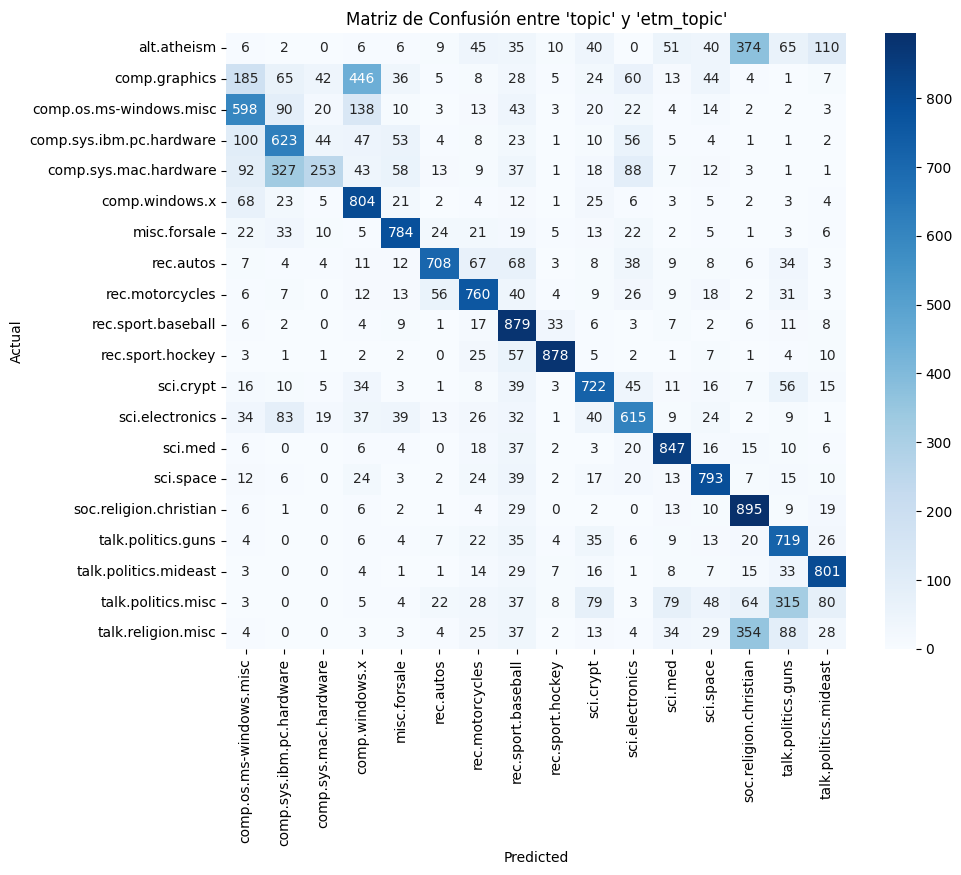

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear la tabla de contingencia como matriz de confusión
matriz_confusion = pd.crosstab(df_newsgroups['topic'], df_newsgroups['etm_topic'], rownames=['Actual'], colnames=['Predicted'])

# Plotear la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Matriz de Confusión entre 'topic' y 'etm_topic'")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


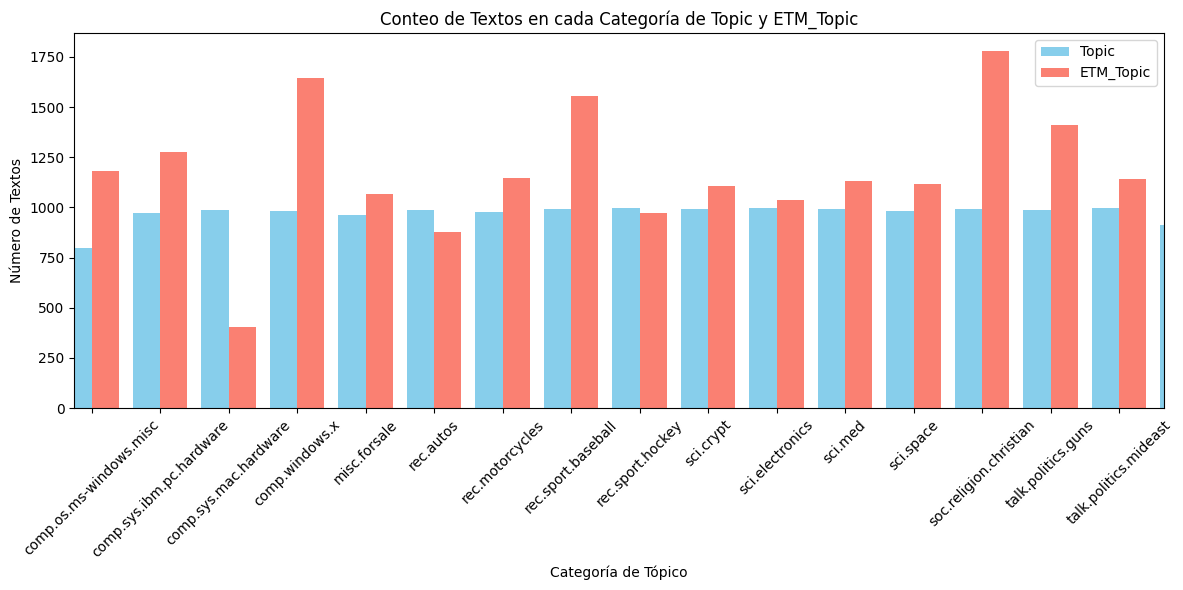

In [ ]:
import matplotlib.pyplot as plt

# Contar la cantidad de textos en cada categoría de 'topic' y 'etm_topic'
topic_counts = df_newsgroups['topic'].value_counts().sort_index()
etm_topic_counts = df_newsgroups['etm_topic'].value_counts().sort_index()

# Crear un gráfico de barras para las dos series de conteo
fig, ax = plt.subplots(figsize=(12, 6))
topic_counts.plot(kind='bar', color='skyblue', ax=ax, width=0.4, position=1, label='Topic')
etm_topic_counts.plot(kind='bar', color='salmon', ax=ax, width=0.4, position=0, label='ETM_Topic')

# Configurar etiquetas y título
plt.title("Conteo de Textos en cada Categoría de Topic y ETM_Topic")
plt.xlabel("Categoría de Tópico")
plt.ylabel("Número de Textos")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


### vMF para DistilBert

VAMOS a:

implementar un modelo vMF usando DistilBERT en cada texto de la columna text del DataFrame df_newsgroups y guardar el resultado como una nueva columna. Usamos los topicos originales para modelar los temas con vMF.

Calculamos el porcentaje de documentos por tópico que fueron asignados correctamente y la coherencia c_v.

In [ ]:
df_newsgroups[:10]

,text,label,topic,distilbert_vector,topic_encoded,etm_topic,tokens
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,"[-0.009046761, -0.19225124, -0.21939902, 0.061...",10,rec.sport.hockey,"[am, sure, some, bashers, of, pens, fans, are,..."
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,"[-0.12930581, -0.10550669, 0.019848287, -0.055...",3,misc.forsale,"[my, brother, is, in, the, market, for, high, ..."
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,"[0.013382235, 0.18851829, -0.08755669, -0.2655...",17,talk.politics.mideast,"[finally, you, said, what, you, dream, about, ..."
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,"[-0.455488, -0.2351872, -0.04610482, 0.1003923...",3,comp.sys.ibm.pc.hardware,"[think, it, the, scsi, card, doing, the, dma, ..."
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,"[-0.1602897, -0.04452682, 0.009270257, -0.1979...",4,comp.sys.ibm.pc.hardware,"[have, an, old, jasmine, drive, which, cannot,..."
5,\n\nBack in high school I worked as a lab assi...,12,sci.electronics,"[-3.0061858e-05, -0.012632432, -0.2691953, -0....",12,sci.electronics,"[back, in, high, school, worked, as, lab, assi..."
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,4,comp.sys.mac.hardware,"[0.008777524, -0.262973, 0.16997282, -0.038989...",4,sci.electronics,"[ae, is, in, dallas, try, or, tech, support, m..."
7,"\n[stuff deleted]\n\nOk, here's the solution t...",10,rec.sport.hockey,"[-0.15373003, 0.00047762913, -0.11355538, -0.0...",10,rec.sport.hockey,"[stuff, deleted, ok, here, the, solution, to, ..."
8,"\n\n\nYeah, it's the second one. And I believ...",10,rec.sport.hockey,"[-0.09745612, -0.24523911, -0.13571888, -0.208...",10,rec.sport.hockey,"[yeah, it, the, second, one, and, believe, tha..."
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,"[0.15699857, 0.03618659, -0.14255995, -0.17546...",19,soc.religion.christian,"[if, christian, means, someone, who, believes,..."


In [ ]:
import numpy as np

df_newsgroups['distilbert_vector'] = df_newsgroups['distilbert_vector'].apply(lambda x: np.array(x, dtype=np.float32))


In [ ]:
import numpy as np
import pandas as pd
import pickle

# Definir el tamaño del bloque
block_size = 100

# Procesar en bloques y guardar cada bloque en archivos temporales
for i, start in enumerate(range(0, len(df_newsgroups), block_size)):
    end = start + block_size
    df_block = df_newsgroups.iloc[start:end].copy()

    # Normalizar embeddings en el bloque
    df_block['embedding'] = df_block['distilbert_vector'].apply(lambda x: x / np.linalg.norm(x) if np.linalg.norm(x) != 0 else x)

    # Guardar el bloque procesado como un archivo temporal
    with open(f'embeddings_block_{i}.pkl', 'wb') as f:
        pickle.dump(df_block[['embedding']], f)

# Para reconstruir el DataFrame final con todas las embeddings
embeddings = []
for i in range((len(df_newsgroups) + block_size - 1) // block_size):
    with open(f'embeddings_block_{i}.pkl', 'rb') as f:
        df_block = pickle.load(f)
        embeddings.extend(df_block['embedding'])

# Agregar la columna embeddings completa al DataFrame
df_newsgroups['embedding'] = embeddings
print(df_newsgroups[['distilbert_vector', 'embedding']].head())








                                   distilbert_vector  \
0  [-0.009046937, -0.19225115, -0.21939921, 0.061...   
1  [-0.12930581, -0.105506726, 0.019848445, -0.05...   
2  [0.013382249, 0.18851815, -0.08755682, -0.2655...   
3  [-0.45548785, -0.23518702, -0.04610508, 0.1003...   
4  [-0.1602896, -0.04452677, 0.0092704715, -0.197...   

                                           embedding  
0  [-0.00076611777, -0.016280318, -0.018579286, 0...  
1  [-0.010451, -0.008527465, 0.0016042287, -0.004...  
2  [0.0011762986, 0.01657073, -0.0076962374, -0.0...  
3  [-0.03704299, -0.019126812, -0.00374954, 0.008...  
4  [-0.01335889, -0.0037109598, 0.00077262166, -0...  


In [ ]:
df_newsgroups[:10]

,text,label,topic,distilbert_vector,embedding,assigned_topic,topic_encoded,etm_topic
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,"[-0.009046937, -0.19225115, -0.21939921, 0.061...","[-0.00076611777, -0.016280318, -0.018579286, 0...",rec.sport.hockey,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,"[-0.12930581, -0.105506726, 0.019848445, -0.05...","[-0.010451, -0.008527465, 0.0016042287, -0.004...",comp.sys.mac.hardware,3,misc.forsale
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,"[0.013382249, 0.18851815, -0.08755682, -0.2655...","[0.0011762986, 0.01657073, -0.0076962374, -0.0...",talk.politics.mideast,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,"[-0.45548785, -0.23518702, -0.04610508, 0.1003...","[-0.03704299, -0.019126812, -0.00374954, 0.008...",comp.windows.x,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,"[-0.1602896, -0.04452677, 0.0092704715, -0.197...","[-0.01335889, -0.0037109598, 0.00077262166, -0...",comp.sys.ibm.pc.hardware,4,comp.sys.ibm.pc.hardware
5,\n\nBack in high school I worked as a lab assi...,12,sci.electronics,"[-2.9996214e-05, -0.012632319, -0.26919523, -0...","[-2.4332596e-06, -0.0010247197, -0.02183682, -...",sci.electronics,12,sci.electronics
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,4,comp.sys.mac.hardware,"[0.008777515, -0.26297286, 0.16997282, -0.0389...","[0.0007864626, -0.023562286, 0.015229512, -0.0...",comp.os.ms-windows.misc,4,comp.sys.mac.hardware
7,"\n[stuff deleted]\n\nOk, here's the solution t...",10,rec.sport.hockey,"[-0.15372993, 0.00047764258, -0.11355502, -0.0...","[-0.012797846, 3.9763218e-05, -0.00945333, -0....",rec.sport.hockey,10,rec.sport.hockey
8,"\n\n\nYeah, it's the second one. And I believ...",10,rec.sport.hockey,"[-0.09745629, -0.24523902, -0.13571864, -0.208...","[-0.008130484, -0.020459551, -0.011322597, -0....",rec.sport.hockey,10,rec.sport.hockey
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,"[0.15699874, 0.036186375, -0.14256015, -0.1754...","[0.013712591, 0.003160592, -0.012451495, -0.01...",talk.religion.misc,19,soc.religion.christian


In [ ]:
import numpy as np

# Assuming 'distilbert_vector' column contains the DistilBERT embeddings
distilbert_embeddings = np.stack(df_newsgroups['distilbert_vector'].values)

# Step 3: Normalize each embedding on a unit sphere and handle zero norms
norms = np.linalg.norm(distilbert_embeddings, axis=1, keepdims=True)
norms[norms == 0] = 1  # Avoid division by zero by replacing zero norms with one
distilbert_embeddings_normalized = distilbert_embeddings / norms

# Step 4: Save the normalized embeddings in the DataFrame
df_newsgroups['embedding'] = list(distilbert_embeddings_normalized)

# Calculate the centroids based on the topics in 'topic'
unique_topics = df_newsgroups['topic'].unique()
centroides_temas = {}

for topic in unique_topics:
    # Get the embeddings of documents for the current topic
    embeddings_tema = np.stack(df_newsgroups[df_newsgroups['topic'] == topic]['embedding'].values)

    # Calculate the normalized centroid for the topic and handle zero norms
    centroide = np.mean(embeddings_tema, axis=0)
    if np.linalg.norm(centroide) == 0:  # If the centroid has zero norm
        centroide = np.ones(centroide.shape)  # Assign a neutral vector of ones
    else:
        centroide = centroide / np.linalg.norm(centroide)  # Normalize the centroid
    centroides_temas[topic] = centroide

# Assign topics based on similarity with each centroid
assigned_topics = []

for embedding in df_newsgroups['embedding']:
    # Calculate the similarity (dot product) with each centroid
    similitudes = {topic: np.dot(embedding, centroide) for topic, centroide in centroides_temas.items()}
    # Assign the topic with the highest similarity
    assigned_topic = max(similitudes, key=similitudes.get)
    assigned_topics.append(assigned_topic)

# Add the assigned topics to the DataFrame
df_newsgroups['assigned_topic'] = assigned_topics

# Display the first few results
print(df_newsgroups[['text', 'topic', 'assigned_topic']].head())



                                                text  \
0  \n\nI am sure some bashers of Pens fans are pr...   
1  My brother is in the market for a high-perform...   
2  \n\n\n\n\tFinally you said what you dream abou...   
3  \nThink!\n\nIt's the SCSI card doing the DMA t...   
4  1)    I have an old Jasmine drive which I cann...   

                      topic            assigned_topic  
0          rec.sport.hockey          rec.sport.hockey  
1  comp.sys.ibm.pc.hardware     comp.sys.mac.hardware  
2     talk.politics.mideast     talk.politics.mideast  
3  comp.sys.ibm.pc.hardware            comp.windows.x  
4     comp.sys.mac.hardware  comp.sys.ibm.pc.hardware  


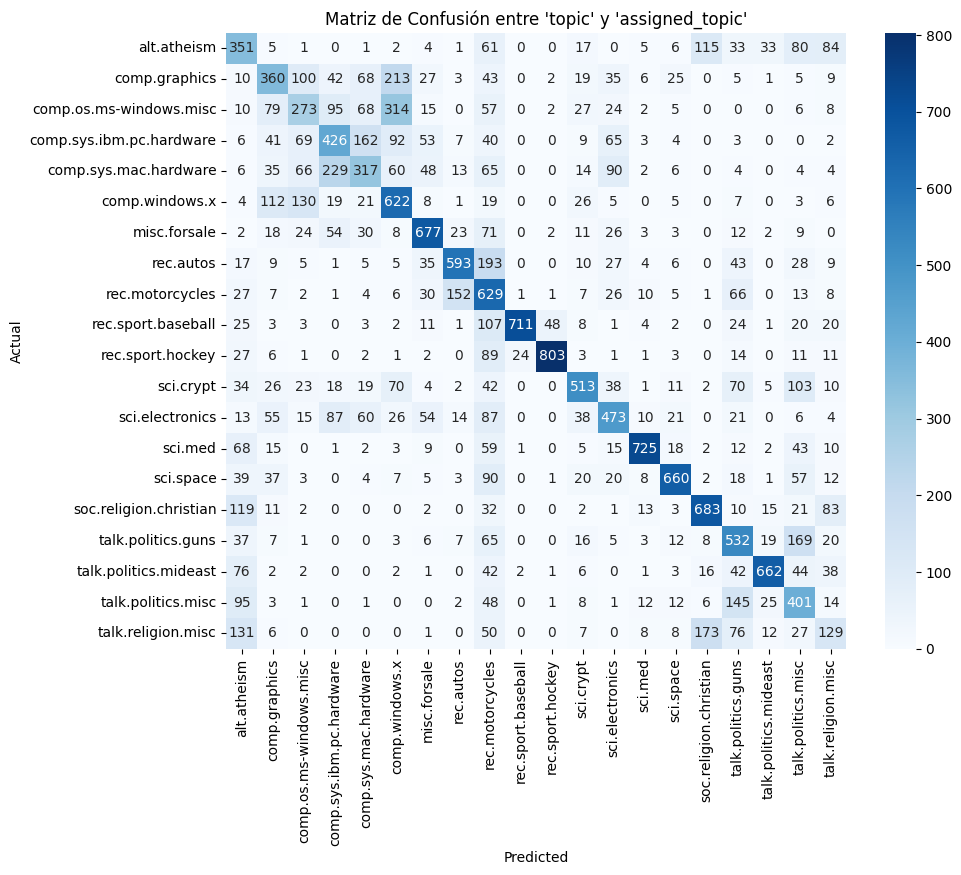

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear la tabla de contingencia como matriz de confusión
matriz_confusion = pd.crosstab(df_newsgroups['topic'], df_newsgroups['assigned_topic'], rownames=['Actual'], colnames=['Predicted'])

# Plotear la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Matriz de Confusión entre 'topic' y 'assigned_topic'")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


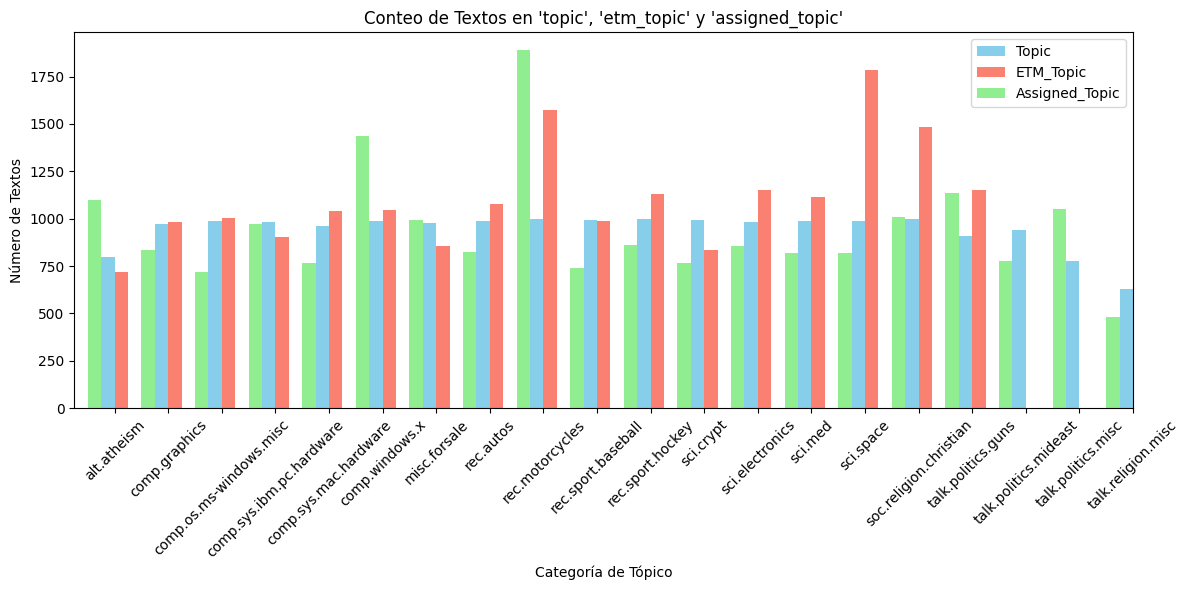

In [ ]:
import matplotlib.pyplot as plt

# Contar la cantidad de textos en cada categoría de 'topic', 'etm_topic' y 'assigned_topic'
topic_counts = df_newsgroups['topic'].value_counts().sort_index()
etm_topic_counts = df_newsgroups['etm_topic'].value_counts().sort_index()
assigned_topic_counts = df_newsgroups['assigned_topic'].value_counts().sort_index()

# Crear un gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))

# Plotear los conteos de 'topic', 'etm_topic' y 'assigned_topic'
topic_counts.plot(kind='bar', color='skyblue', ax=ax, width=0.25, position=1, label='Topic')
etm_topic_counts.plot(kind='bar', color='salmon', ax=ax, width=0.25, position=0, label='ETM_Topic')
assigned_topic_counts.plot(kind='bar', color='lightgreen', ax=ax, width=0.25, position=2, label='Assigned_Topic')

# Configurar etiquetas y título
plt.title("Conteo de Textos en 'topic', 'etm_topic' y 'assigned_topic'")
plt.xlabel("Categoría de Tópico")
plt.ylabel("Número de Textos")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [ ]:
# Contar coincidencias exactas entre 'topic' y 'assigned_topic'
coincidencias = (df_newsgroups['topic'] == df_newsgroups['assigned_topic']).sum()

# Calcular la accuracy dividiendo las coincidencias por el total de documentos
accuracy = coincidencias / len(df_newsgroups)

# Mostrar el resultado
print(f"La accuracy es: {accuracy:.4f}")


La accuracy es: 0.5593


In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim

# Preprocess text into tokens for coherence calculation
df_newsgroups['tokens'] = df_newsgroups['text'].apply(lambda x: gensim.utils.simple_preprocess(x))

# Group tokens by the assigned ETM topic, and flatten each group to get a single list of words per topic
topic_words = df_newsgroups.groupby('assigned_topic')['tokens'].apply(lambda docs: [word for tokens in docs for word in tokens]).tolist()

# Create a Gensim dictionary from all tokens
dictionary = Dictionary(df_newsgroups['tokens'])

# Compute coherence score using c_v (you can change this to u_mass, c_uci, or c_npmi if preferred)
coherence_model = CoherenceModel(topics=topic_words, texts=df_newsgroups['tokens'].tolist(),
                                 dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f"Coherence score for ETM topics: {coherence_score:.4f}")

Coherence score for ETM topics: 0.3656
